In [31]:
!python3 -m pip install pandas
!python3 -m pip install 'pycaret[full]'
!python3 -m pip install 'pycaret[tuners]'
!python3 -m pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [32]:
from pycaret.classification import *
import pandas as pd
import numpy as np

<h2>1. 데이터 로드 및 전처리</h2>

In [33]:
# 1. 데이터 로드

data = pd.read_csv('MCHAT.csv')
#data = data.drop(['InspectDate','1st_Screening_ASD_Criteria', 'Congenital_Genetic_Disorder','History_of_Brain_Damage', 'Seizure_or_Neurological_disease', 'Total_Score','SurveyApplicableMonthAge'], axis = 1)


# https://github.com/skwgbobf/ASD_Kaggle/blob/main/4.Kaggle1_%20BERT%20Classification.ipynb

# train test 8:2로 나눕니다.
np.random.seed(112)
train, test = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(data))])

print(len(train), len(test))

114 29


In [34]:
data.head().T

,0,1,2,3,4
Subject_Id,1023032001,1023041312,1523091554,1523101651,1523102651
Gender,f,f,f,m,m
Class/ASD,0,0,0,0,0
Family_History,0.0,0.0,0.0,0.0,0.0
Age,19.0,19.0,21.0,30.0,30.0
Q1,0,0,0,0,0
Q2,0,0,0,0,0
Q3,0,0,0,0,0
Q4,0,0,0,0,0
Q5,0,0,0,0,0


In [35]:
# 2. Preprocess

# Categorical Data 숫자형으로 변환

# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook
from sklearn import preprocessing

# 데이터 칼럼 추출
cat_cols = list(train.select_dtypes('object').columns.values)

# 전처리 과정을 위해서 train과 test 셋들을 잠시 합칩니다.
df = pd.concat([train, test], axis=0)

# 데이터 타입을 모두 숫자형으로 통일
label_encoder = preprocessing.LabelEncoder()
for col in cat_cols:
    df[col]= label_encoder.fit_transform(df[col])

# train test를 다시 8:2로 나눕니다
train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]

In [36]:
import enum
import random
import os

# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

# 사용할 시드값 변환 함수
def random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# 시드값, CV fold 개수, 훈련 조기중단 변수 설정
class Config(enum.Enum):
    SEED = 42
    N_FOLDS = 5
    EARLY_STOP = 300

random_seed(Config.SEED.value)

<h2>2. XGBoost Hypter Parameter 설명 </h2> 


XGBoost + SHAP (하이퍼 파라미터 사용) <br>
https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

DMatrix() 사용 불가능 - DMatrix는 모델 학습 속도 상승 효과만 있음 <br>
pycaret에서 early stopping method 사용 불가능 / xgboost에서만 가능 - 모델 학습 속도 사응 효과만 있음 <br>
https://xgboost.readthedocs.io/en/stable/python/python_api.html



In [37]:
# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

# xgboost 하이퍼파라미터 세팅
xgb_params=  {'n_estimators': 10000,
              'learning_rate': 0.002,
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'max_depth': 10,
              'alpha': 0.5108154566815425,
              'gamma': 1.9276236172849432,
              'reg_lambda': 11.40999855634382,
              'colsample_bytree': 0.705851334291963,
              'subsample': 0.8386116751473301,
              'min_child_weight': 2.5517043283716605,
              #'early_stopping_rounds': Config.EARLY_STOP.value, # 학습 도중 모델이 발전이 없을 때 학습을 멈출 수 있게 하는 파라미터들
              #'evals' = [(dtrain, 'train'), (deval, 'eval')],   # pycaret에서 사용 불가능 / xgboost에서만 가능
              #'verbose_eval': 1000, 

}

<h2> 3. Model definition and Training</h2>

Pycaret Classification <br>
https://www.kaggle.com/code/venkatkumar001/apc-3-pycaret-identify-best-algo-s/notebook

학습 모델: XGBoost <br>
evaludation 방식: Stratified K-fold Cross Validation 

In [38]:
# 3. Training

# https://www.kaggle.com/code/venkatkumar001/apc-3-pycaret-identify-best-algo-s/notebook

import xgboost as xgb

# 모델 생성에 사용될 설정
reg = setup(data=train, # 
           target= 'Class/ASD', # columns = [col for col in train.columns if col not in ['ID', 'age_desc', 'Class/ASD'] ] 
           session_id = Config.SEED.value, # random_state = Config.SEED.value
           verbose = False, # silent = True
           fold = Config.N_FOLDS.value, # n_splits = Config.F_FOLDS.value
           data_split_shuffle = True, # shuffle = True
           ignore_features = ['Subject_Id'] # columns = [col for col in train.columns if col not in ['ID', 'age_desc', 'Class/ASD'] ] 
           )

print("모델 생성 및 training 결과")
# 모델 생성: XGBoost + Stratified K-fold Cross-Validation 사용
xgboost = create_model(
    'xgboost',
    **xgb_params # xgboost 모델에 hyper parameter 입력
    )

print("Hyper Parameter 튜닝 결과")
# hyper parameter 튜닝 (Random Grid Search 사용)
tuned_xgboost = tune_model(xgboost)

# 모델 예측
predict_value = tuned_xgboost.predict(test.drop(['Subject_Id',  'Class/ASD', ], axis = 1)) # shap_preds = tuned_xgboost.predict(test)

모델 생성 및 training 결과


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.9062,1.0000,0.7500,0.8571,0.0000,0.0000
1,0.7500,0.9583,1.0000,0.7500,0.8571,0.0000,0.0000
2,0.7500,0.7500,1.0000,0.7500,0.8571,0.0000,0.0000
3,0.7500,0.7500,1.0000,0.7500,0.8571,0.0000,0.0000
4,0.7333,0.9091,1.0000,0.7333,0.8462,0.0000,0.0000
Mean,0.7467,0.8547,1.0000,0.7467,0.8549,0.0000,0.0000
Std,0.0067,0.0875,0.0000,0.0067,0.0044,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Hyper Parameter 튜닝 결과


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.9167,1.0000,0.7500,0.8571,0.0000,0.0000
1,0.7500,0.8646,1.0000,0.7500,0.8571,0.0000,0.0000
2,0.7500,0.8542,1.0000,0.7500,0.8571,0.0000,0.0000
3,0.7500,0.8750,0.8333,0.8333,0.8333,0.3333,0.3333
4,0.8000,0.6705,1.0000,0.7857,0.8800,0.3284,0.4432
Mean,0.7600,0.8362,0.9667,0.7738,0.8570,0.1323,0.1553
Std,0.0200,0.0855,0.0667,0.0328,0.0148,0.1621,0.1934


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [39]:
reg.get_config('X_train').head().T

,47,124,54,19,91
Gender,1.0,1.0,1.0,1.0,1.0
Family_History,0.0,0.0,0.0,0.0,0.0
Age,29.0,26.0,21.0,20.0,25.0
Q1,0.0,0.0,0.0,0.0,0.0
Q2,1.0,1.0,0.0,0.0,1.0
Q3,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,1.0,0.0
Q5,0.0,0.0,0.0,0.0,1.0
Q6,0.0,0.0,0.0,0.0,0.0
Q7,0.0,0.0,0.0,0.0,1.0


<h2>4. SHAP Visualization</h2>

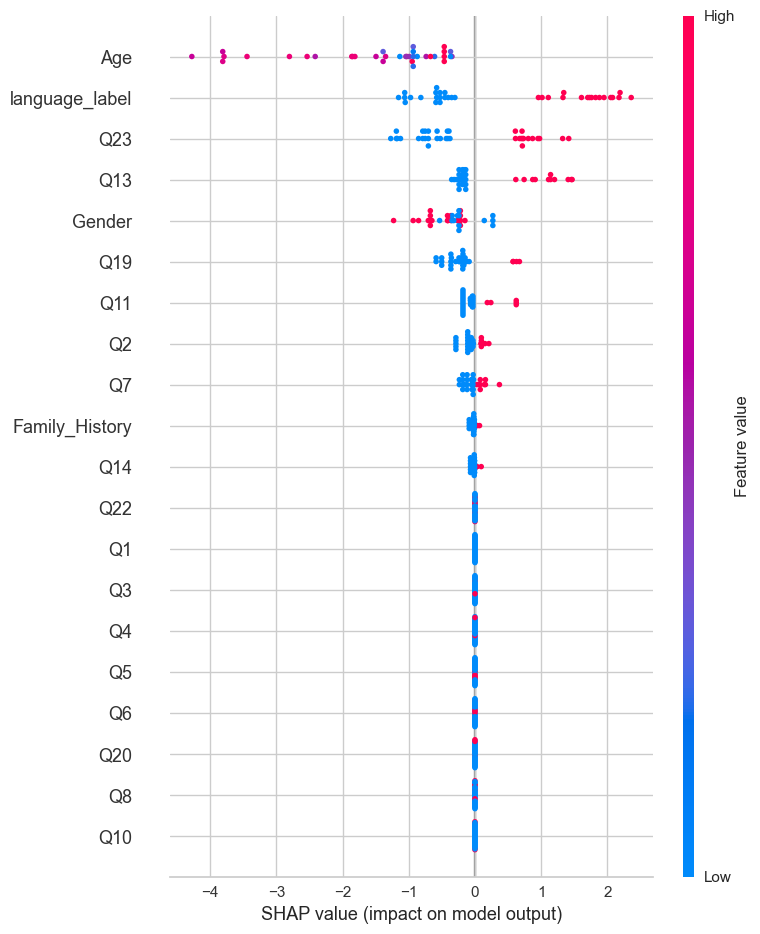

In [40]:
# SHAP 결과
interpret_model(tuned_xgboost, plot = 'summary')
interpret_model(tuned_xgboost, plot = 'msa')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

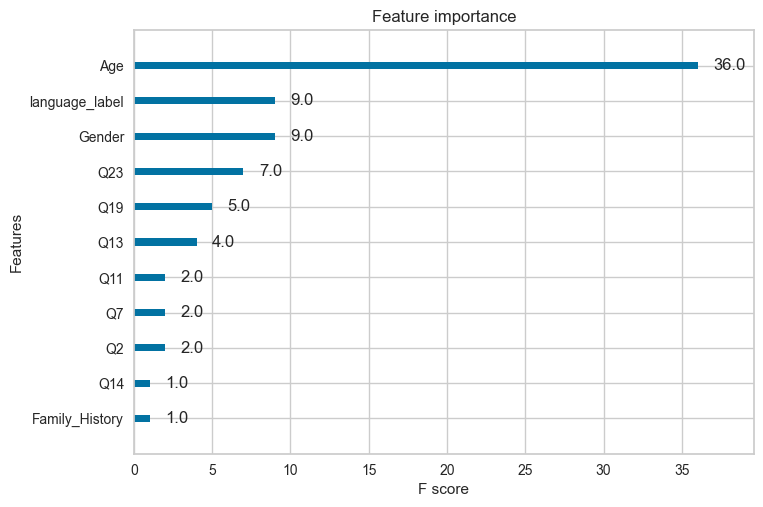

In [42]:
xgb.plot_importance(tuned_xgboost)

In [41]:
predict_model(tuned_xgboost, data = test)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7586,0.7391,0.9565,0.7857,0.8627,-0.0628,-0.0965


,Subject_Id,Gender,Family_History,Age,Q1,Q2,Q3,Q4,Q5,Q6,...,Q19,Q20,Q21,Q22,Q23,ethnicity,language_label,Class/ASD,prediction_label,prediction_score
88,1123042711,1,0.0,18.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,1,1,0.9865
126,1123112711,1,0.0,30.0,0,1,1,0,0,0,...,0,0,0,1,1,0,1.0,1,1,0.9996
21,1024041433,0,0.0,24.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0,1,0.9844
57,1023120582,0,0.0,28.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.0,1,1,0.9992
75,1024031342,1,0.0,28.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0.0,1,1,0.9736
32,1024052883,0,0.0,18.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0,1,0.9854
137,1024021381,1,0.0,29.0,0,1,1,0,0,0,...,0,0,0,1,1,0,1.0,1,1,0.9979
59,1023121362,0,0.0,27.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,1,1,0.5341
63,1323122811,0,0.0,24.0,1,1,0,0,0,1,...,0,0,0,0,1,0,1.0,1,1,0.9998
128,1123122011,1,0.0,28.0,0,0,1,0,0,0,...,0,0,0,0,1,0,1.0,1,1,0.9971
